# Keras Data Loaders and Augmentator

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Data-Generator" data-toc-modified-id="Image-Data-Generator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Data Generator</a></span></li><li><span><a href="#NPY-CUSTOM-KERAS-Data-Generator" data-toc-modified-id="NPY-CUSTOM-KERAS-Data-Generator-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NPY CUSTOM KERAS Data Generator</a></span><ul class="toc-item"><li><span><a href="#Initialization-of-custom-generators" data-toc-modified-id="Initialization-of-custom-generators-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialization of custom generators</a></span></li><li><span><a href="#Test-generator-with-sample-models" data-toc-modified-id="Test-generator-with-sample-models-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test generator with sample models</a></span></li><li><span><a href="#Evaluate-Generator" data-toc-modified-id="Evaluate-Generator-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Evaluate Generator</a></span></li><li><span><a href="#Predict-Generator" data-toc-modified-id="Predict-Generator-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Predict Generator</a></span></li><li><span><a href="#Example-of-what-generators-returns" data-toc-modified-id="Example-of-what-generators-returns-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Example of what generators returns</a></span></li></ul></li><li><span><a href="#OPTIMICE-APPROACHS" data-toc-modified-id="OPTIMICE-APPROACHS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OPTIMICE APPROACHS</a></span><ul class="toc-item"><li><span><a href="#Tf.Data" data-toc-modified-id="Tf.Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tf.Data</a></span></li></ul></li><li><span><a href="#IMAGES---FROM-PNG" data-toc-modified-id="IMAGES---FROM-PNG-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>IMAGES - FROM PNG</a></span><ul class="toc-item"><li><span><a href="#Keras-Flow_from_directory" data-toc-modified-id="Keras-Flow_from_directory-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Keras Flow_from_directory</a></span></li><li><span><a href="#TF.Data-a-mano" data-toc-modified-id="TF.Data-a-mano-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>TF.Data a mano</a></span></li></ul></li></ul></div>

**OPTIONS**

  * ImageDataGenerator + imgaug
  * ImageDataGenerator + tf.keras.layers.experimental.preprocessing
  * **DATAAUG:** `tf.image`
     * https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization?version=nightly
     * https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_preprocessing_layers
     * **DAUG**: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb?hl=es#scrollTo=R5fGVMqlFxF7
   

**Libraries**

* **ImageDataGenerator:**
   * CPU
   * No easy Custom preprocessing techniques
   * From directory
   * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly
   * https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function
   * https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
   * https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
   * https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
   * https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
 
* **imgaug**
     * Extra-Library: no optimized neither for Keras nor TF.
* **tf.keras.layers.experimental.preprocessing**
    * GPU
    * https://keras.io/guides/preprocessing_layers/
    * https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
       

In [1]:
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


The first option is to turn on memory growth by calling `tf.config.experimental.set_memory_growth`, which attempts to allocate only **as much GPU memory as needed for the runtime allocation**s: it **starts out allocating very little memory**, and as the program gets run and **more GPU memory is needed, we extend the GPU memory region** allocated to the TensorFlow process. ***Note we do not release memory, since it can lead to memory fragmentation***. To turn on memory growth for a specific GPU, use the following code prior to allocating any tensors or executing any ops.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = True

In [3]:
import pandas as pd
import glob
import random
import time
import matplotlib.pyplot as plt
import os

GLOBAL_BATCH_SIZE = 8

tf.__version__, tf.test.is_built_with_cuda(), tf.config.experimental.list_physical_devices('GPU')

('2.3.1',
 True,
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Image Data Generator

It inclues a easy api, and different ways of data load.

**Downside**: 
* Only reads jpg, png... but it do not read npy files (we have stores numpy files in order to keep the original values of each pixel)
* Preprocessing and augmentation are made in CPU




```python
train_datagen = keras.preprocessing.image.ImageDataGenerator(..., validation_split=0.2) # OJO set validation split

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(PATH,
                                                 subset='training',
                                                 class_mode='input', #OJOOOO,
                                                 color_mode='grayscale',
                                                 shuffle=True,
                                                 #save_to_dir='dir prueba' para testear el augmentado,
                                                 #save_format='png',
                                                 target_size = (64, 64),
                                                 batch_size = 32)

validation_set = validation_datagen.flow_from_directory(PATH,
                                                        subset='validation',
                                                        class_mode='input', #OJOOOO
                                                        target_size = (64, 64),
                                                        batch_size = 32)
model = create_model()

# steps_per_epoch should be (number of training images total // batch_size) 
# validation_steps should be (number of validation images total // batch_size) 
model.fit(training_set,
          steps_per_epoch = 8000,
          epochs = 5,
          validation_data = validation_set,
          validation_steps = 2000)
```

## NPY CUSTOM KERAS Data Generator
**We made a custom data generator to have mor control in preprocessing and data augmentation**

**Returns a tuple with batch of input images (maybe augmented) on [0] and batch of output images on [1]**

**X images could be augmented. Dimensions = (256,256,1) to be fitted in Convolutional Autoencoder**

### Initialization of custom generators

In [4]:
from my_data_loader import DataGenerator

In [5]:
#Partition
train_percentage = 0.85

MAIN_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'img'+os.path.sep+'train_and_val'
trainval_files = glob.glob(MAIN_PATH+os.path.sep+'*.npy')
random.shuffle(trainval_files)

lim = int(len(trainval_files)*train_percentage)
train_files = trainval_files[:lim]
validation_files = trainval_files[lim:]

test_files = glob.glob('../IXI-T1/img/test/*.npy')


In [6]:
# Parameters
params = {'dim': (256,256),
          'batch_size': GLOBAL_BATCH_SIZE,
          'n_channels': 1,
          'shuffle': True,
          'std_normalization': True,
         }
# Generators
train_generator = DataGenerator(train_files, **params)
validation_generator = DataGenerator(validation_files, **params)

train_generator.samples, train_generator.samples // train_generator.batch_size

(46285, 5785)

### Test generator with sample models

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Sequential

def build_model_1(i_shape, batch_size):
    input_layer = Input(shape=i_shape, batch_size=batch_size, name = "Image")
    
    #Preprocessing
    
    
    
    """https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
    resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255)
    ])
    
    """
    # encoder
    h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    h = MaxPooling2D((2, 2), padding='same')(h)

    # decoder
    h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    h = UpSampling2D((2, 2))(h)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

    return Model(input_layer, output_layer)


def build_model_2(input_shape, batch_size):
    def autoencoder(input_img):
        #encoder
        #input = 256 x 256 x 1 (wide and thin)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #256 x 256 x 32
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #128 x 128 x 32

        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #128 x 128 x 64
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #64 x 64 x 64

        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #64 x 64 x 128 (small and thick)
        conv3 = BatchNormalization()(conv3)


        #decoder
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
        conv4 = BatchNormalization()(conv4)
        up1 = UpSampling2D((2,2))(conv4) # 128 x 128 x 128
        
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 128 x 128 x 64
        conv5 = BatchNormalization()(conv5)
        up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
        
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 256 x 256 x 1
        
        return decoded

    input_img = Input(shape = input_shape, batch_size=batch_size)
    return Model(input_img, autoencoder(input_img))


def build_model_3(input_shape, batch_size):
    
    # ENCODER
    input_img = Input(shape=input_shape, batch_size = batch_size)  
    x = Conv2D(48, (3, 3), activation='relu', padding='same', name = 'eCONV1')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same', name = 'eCONV2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same', name = 'eCONV3')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(32, (1, 1), activation='relu', padding='same', name = 'eCONV4')(x)

    # LATENT SPACE
    latentSize = (int(input_shape[0]/8),int(input_shape[1]/8),32)

    # DECODER
    direct_input = Input(shape=latentSize, batch_size = batch_size)
    x = Conv2D(192, (1, 1), activation='relu', padding='same', name = 'dCONV1')(direct_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same', name = 'dCONV2')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same', name = 'dCONV3')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(48, (3, 3), activation='relu', padding='same', name = 'dCONV4')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'to1channel')(x)

    # COMPILE
    encoder = Model(input_img, encoded, name='ENCOER')
    decoder = Model(direct_input, decoded, name='DECODER')
    return  Model(input_img, decoder(encoded), name='AUTOENCODER')
    

In [8]:
autoencoder =  build_model_2((256,256,1),  train_generator.batch_size)   
autoencoder.compile(loss='mse', optimizer='Adam')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(8, 256, 256, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (8, 256, 256, 32)         320       
_________________________________________________________________
batch_normalization (BatchNo (8, 256, 256, 32)         128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (8, 128, 128, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (8, 128, 128, 64)         18496     
_________________________________________________________________
batch_normalization_1 (Batch (8, 128, 128, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (8, 64, 64, 64)          

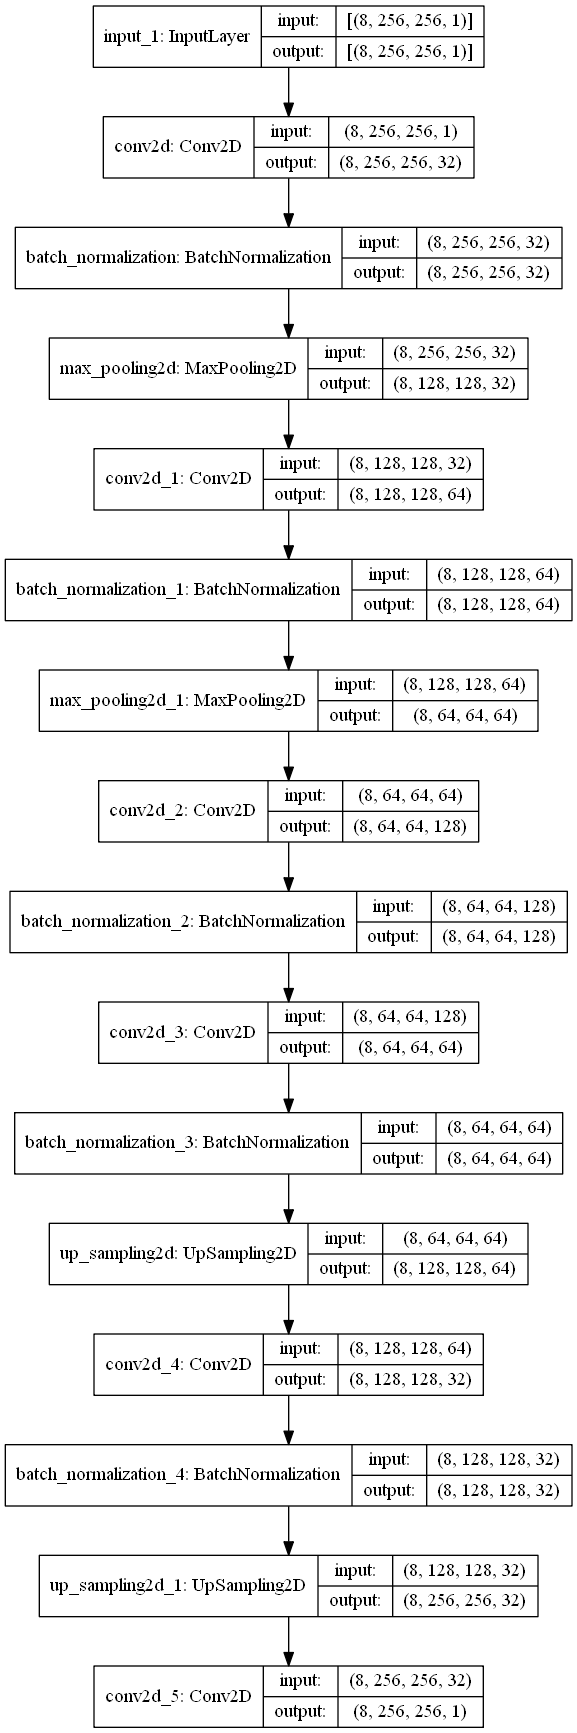

In [9]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True)

In [9]:
train_generator.samples // train_generator.batch_size

5785

 `max_queue_size=10`, `use_multiprocessing=True`, `workers=16` Only used if Generator is instance of **SEQUENCE**

In [10]:
STEP_SIZE_TRAIN = train_generator.samples // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.samples // validation_generator.batch_size

In [11]:


'''early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')'''

#from tensorflow.keras.callbacks import CSVLogger, ProgbarLogger
#csv_logger = CSVLogger('CHECKtraining.log')

#tf.debugging.set_log_device_placement(False)

  
start = time.time()
    
autoencoder_train = autoencoder.fit(train_generator,
                                    epochs=2, 
                                    steps_per_epoch = STEP_SIZE_TRAIN,
                                    validation_data = validation_generator, 
                                    validation_steps = STEP_SIZE_VALID,
                                    verbose=1,
                                    max_queue_size=15,
                                    use_multiprocessing=True,
                                    workers=12
                                   )
end = time.time()

Epoch 1/2
5785/5785 [==============================] - 307s 53ms/step - loss: 0.4963 - val_loss: 0.4932
Epoch 2/2
5785/5785 [==============================] - 318s 55ms/step - loss: 0.4927 - val_loss: 0.4925


In [12]:
end-start

679.8946011066437

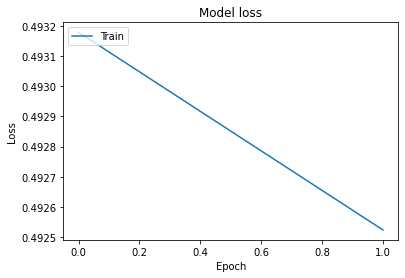

In [13]:
import matplotlib.pyplot as plt
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

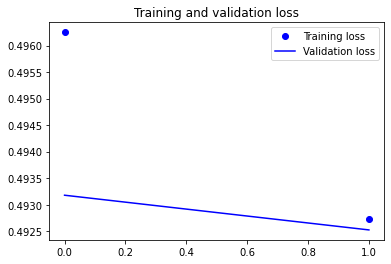

In [14]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(2)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluate Generator

### Predict Generator

### Example of what generators returns

## OPTIMICE APPROACHS
### Tf.Data
https://www.tensorflow.org/guide/data_performance?hl=en

https://towardsdatascience.com/dump-keras-imagedatagenerator-start-using-tensorflow-tf-data-part-2-fba7cda81203

In [15]:
tf.executing_eagerly()

True

In [16]:
def load_data_using_tfdata(files, batch_size = 4, std_norm = True, cache_img=False):
    """
    Load the images in batches using Tensorflow (tfdata).
    Cache can be used to speed up the process.
    Faster method in comparison to image loading using Keras.
    Returns:
    Data Generator to be used while training the model.
    https://towardsdatascience.com/dump-keras-imagedatagenerator-start-using-tensorflow-tf-data-part-2-fba7cda81203
    """
    import numpy as np
    def parse_image(file_path):
        # load the raw data from the file as a string
        img = tf.cast(np.load(file_path.numpy()), tf.float32)
        #img = tf.io.read_file(file_path)
        img = tf.expand_dims(img, axis=2)
        
        #PREPROCESSING
        # resize the image to the desired size.
        # img = tf.image.resize(img, [img_dims[0], img_dims[1]], method=tf.image.ResizeMethod.GAUSSIAN, antialias=True)
        if std_norm:
            img = tf.math.divide(tf.math.subtract(img, tf.math.reduce_mean(img)),
                                 tf.math.reduce_std(img))
            
        return img, tf.identity(img)
        
        #return tf.data.Dataset.zip((tf.data.Dataset.from_tensors(img), tf.data.Dataset.from_tensors(tf.identity(img))))


    def prepare_for_training(ds, cache=False, shuffle_buffer_size=1000):
        # If a small dataset, only load it once, and keep it in memory.
        # use `.cache(filename)` to cache preprocessing work for datasets
        # that don't fit in memory.
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()
                
        #https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        
        # representing the number of times the dataset should be repeated. 
        # The default behavior (if count is None or -1) is for the dataset be repeated indefinitely.
        ds = ds.repeat()
        ds = ds.batch(batch_size)
        
        '''AUGMENTATION
        aug_ds = train_ds.map(
                          lambda x, y: (resize_and_rescale(x, training=True), y))'''
        
        # `prefetch` lets the dataset fetch batches in the background
        # while the model is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #Get all path files
    list_ds = tf.data.Dataset.from_tensor_slices(files)
    
    # Set `num_parallel_calls` so that multiple images are
    # processed in parallel
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    labeled_ds = list_ds.map(lambda item: tf.py_function(parse_image, [item],
                                                                [tf.float32, tf.float32]),
                                    num_parallel_calls=AUTOTUNE)
    '''INTERLEAVE PARALELIZE
    labeled_ds = list_ds.interleave(lambda item: tf.py_function(parse_image, [item],
                                                                tf.float32),
                                    num_parallel_calls=AUTOTUNE)'''
    #labeled_ds = list_ds.interleave(tf.py_function(parse_image), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # cache = True, False, './file_name'
    # If the dataset doesn't fit in memory use a cache file,
    # eg. cache='./data.tfcache'
    
    return prepare_for_training(labeled_ds, cache=cache_img) #'cocodata.tfcache'



In [17]:
params = {'batch_size': GLOBAL_BATCH_SIZE,
          'cache_img':False
         }

train_generator = load_data_using_tfdata(train_files, **params)
validation_generator = load_data_using_tfdata(validation_files, **params)

autoencoder =  build_model_2((256,256,1),  params.get('batch_size'))   
autoencoder.compile(loss='mse', optimizer='Adam')
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(8, 256, 256, 1)]        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (8, 256, 256, 32)         320       
_________________________________________________________________
batch_normalization_5 (Batch (8, 256, 256, 32)         128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (8, 128, 128, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (8, 128, 128, 64)         18496     
_________________________________________________________________
batch_normalization_6 (Batch (8, 128, 128, 64)         256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (8, 64, 64, 64)          

In [18]:
len(train_files) // params.get('batch_size')

5785

In [19]:
STEP_SIZE_TRAIN = len(train_files) // params.get('batch_size')
STEP_SIZE_VALID = len(validation_files) // params.get('batch_size')
  
start = time.time()
    
autoencoder_train = autoencoder.fit(train_generator,
                                    epochs=2, 
                                    steps_per_epoch = STEP_SIZE_TRAIN,
                                    validation_data = validation_generator, 
                                    validation_steps = STEP_SIZE_VALID,
                                    verbose=1
                                    #max_queue_size=15,
                                    #use_multiprocessing=True,
                                    #workers=12
                                    
                                   )
end = time.time()

Epoch 1/2
5785/5785 [==============================] - 351s 61ms/step - loss: 0.4962 - val_loss: 0.4929
Epoch 2/2
5785/5785 [==============================] - 353s 61ms/step - loss: 0.4926 - val_loss: 0.4917


In [20]:
end-start

707.2832615375519

## IMAGES - FROM PNG

### Keras Flow_from_directory

### TF.Data a mano

DAUG: https://keras.io/examples/vision/image_classification_from_scratch/
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb?hl=es#scrollTo=R5fGVMqlFxF7
TOP

```python
def load_img_data_using_tfdata(files, batch_size = 4, std_norm = True, cache_img=False):

    def parse_image(file_path):
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        # convert the compressed string to a 3D float tensor
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        #PREPROCESSING
        # resize the image to the desired size.
        # img = tf.image.resize(img, [img_dims[0], img_dims[1]], method=tf.image.ResizeMethod.GAUSSIAN, antialias=True)
        if std_norm:
            img = tf.math.divide(tf.math.subtract(img, tf.math.reduce_mean(img)),
                                 tf.math.reduce_std(img))
        return img, tf.identity(img)
        

    def prepare_for_training(ds, cache=False, shuffle_buffer_size=1000):
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()       
        #HERE preprocessing
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        #HERE Augmentation that works with one image at a time 
        ds = ds.batch(batch_size)
        #HERE AUGMENTATION works on batches ON CPU - Better option: first layers of model
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    list_ds = tf.data.Dataset.from_tensor_slices(files)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    labeled_ds = list_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
    return prepare_for_training(labeled_ds, cache=cache_img)

```

In [125]:
MAIN_img_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'PNG'+os.path.sep+'train_val_folder'+os.path.sep+'train_and_val'
trainval_img_files = glob.glob(MAIN_img_PATH+os.path.sep+'*.png')
random.shuffle(trainval_img_files)

lim = int(len(trainval_img_files)*train_percentage)
train_img_files = trainval_img_files[:lim]
validation_img_files = trainval_img_files[lim:]

test_img_files = glob.glob('..\\IXI-T1\\PNG\\test_folder\\test\\*.png')

params = {'batch_size': GLOBAL_BATCH_SIZE,
          'cache':False,
          'shuffle_buffer_size':1000
         }

trainds = tf_data_png_loader(train_img_files, 
                             **params
                            ).get_tf_ds_generator()

validation_ds = tf_data_png_loader(validation_img_files, 
                             **params
                            ).get_tf_ds_generator()

autoencoder =  build_model_2((256,256,1),  params.get('batch_size'))   
autoencoder.compile(loss='mse', optimizer='Adam')
autoencoder.summary()
STEP_SIZE_TRAIN = len(train_files) // params.get('batch_size')
STEP_SIZE_VALID = len(validation_files) // params.get('batch_size')
  
start = time.time()
    
autoencoder_train = autoencoder.fit(train_ds,
                                    epochs=2, 
                                    steps_per_epoch = STEP_SIZE_TRAIN,
                                    validation_data = validation_ds, 
                                    validation_steps = STEP_SIZE_VALID,
                                    verbose=1
                                    #max_queue_size=15,
                                    #use_multiprocessing=True,
                                    #workers=12
                                    
                                   )
end = time.time()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(8, 256, 256, 1)]        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (8, 256, 256, 32)         320       
_________________________________________________________________
batch_normalization_20 (Batc (8, 256, 256, 32)         128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (8, 128, 128, 32)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (8, 128, 128, 64)         18496     
_________________________________________________________________
batch_normalization_21 (Batc (8, 128, 128, 64)         256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (8, 64, 64, 64)          

KeyboardInterrupt: 

In [27]:
end-start

512.9202103614807